<a href="https://colab.research.google.com/github/morgansaras27/MAE598-FinalProject/blob/master/NN_RNA_Degradation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from keras import backend as K
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

############ Upload Data #####################
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/")
os.listdir()

############ Loading Data #####################
train = pd.read_json("train.json", lines=True)
test = pd.read_json('test.json', lines=True)
sub = pd.read_csv('sample_submission.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
########### Sequence Process #################
def count_sequence(data):
    temp3 = [[0 for x in range(4)] for y in range(data['sequence'].shape[0])]
    temp = data['sequence'].apply(lambda x: pd.Series(list(x)))
    for j in range(data['sequence'].shape[0]):
        temp2=temp.iloc[j].tolist()
        G = C = A = U = 0
        G_Percent = C_Percent = A_Percent = U_Percent = 0
        for i in range(len(temp2)):
            if temp2[i]=='G':
                G+=1
            elif temp2[i]=='C':
                C += 1
            elif temp2[i] == 'A':
                A += 1
            elif temp2[i] == 'U':
                U += 1
        G_Percent = G / (G+A+U+C)
        C_Percent = C / (G+A+U+C)
        A_Percent = A / (G+A+U+C)
        U_Percent = U / (G+A+U+C)
        temp3[j]=[A_Percent, G_Percent, C_Percent, U_Percent]
    # return temp2,G,C,A,U,G_Percent,C_Percent,A_Percent,U_Percent
    bases = pd.DataFrame(temp3, columns=['A_percent','G_percent','C_percent','U_percent'])
    return bases
# print(count_sequence(train))

########### Structure Process #################
def count_structure(data):
    temp3 = [[0 for x in range(1)] for y in range(data['sequence'].shape[0])]
    temp = data['structure'].apply(lambda x: pd.Series(list(x)))
    for j in range(data['structure'].shape[0]):
        temp2 = temp.iloc[j].tolist()
        End_Pair = Start_Pair = No_Pair = 0
        End_Pair_Percent = Start_Pair_Percent = No_Pair_Percent = 0
        for i in range(len(temp2)):
            if temp2[i]=='(':
                Start_Pair+=1
            elif temp2[i]=='.':
                No_Pair += 1
            elif temp2[i] == ')':
                End_Pair += 1
        Start_Pair_Percent = Start_Pair / (Start_Pair+No_Pair+End_Pair)
        No_Pair_Percent = No_Pair / (Start_Pair+No_Pair+End_Pair)
        End_Pair_Percent = End_Pair / (Start_Pair+No_Pair+End_Pair)
        temp3[j] = [Start_Pair/53.5]
    # return temp2,Start_Pair,No_Pair,End_Pair,Start_Pair_Percent,No_Pair_Percent,End_Pair_Percent
    pairs_rate = pd.DataFrame(temp3, columns=['pairs_rate'])
    return pairs_rate

# print(count_structure(train))

############Pairs #################################
def do_pairs(data):
    pairs = []
    all_partners = []
    for j in range(len(data)):
        partners = [-1 for i in range(130)]
        pairs_dict = {}
        queue = []
        for i in range(0, len(data.iloc[j]['structure'])):
            if data.iloc[j]['structure'][i] == '(':
                queue.append(i)
            if data.iloc[j]['structure'][i] == ')':
                first = queue.pop()
                try:
                    pairs_dict[(data.iloc[j]['sequence'][first], data.iloc[j]['sequence'][i])] += 1
                except:
                    pairs_dict[(data.iloc[j]['sequence'][first], data.iloc[j]['sequence'][i])] = 1

                partners[first] = i
                partners[i] = first

        all_partners.append(partners)

        pairs_num = 0
        pairs_unique = [('U', 'G'), ('C', 'G'), ('U', 'A'), ('G', 'C'), ('A', 'U'), ('G', 'U')]
        for item in pairs_dict:
            pairs_num += pairs_dict[item]
        add_tuple = list()
        for item in pairs_unique:
            try:
                add_tuple.append(pairs_dict[item] / pairs_num)
            except:
                add_tuple.append(0)
        pairs.append(add_tuple)

    pairs = pd.DataFrame(pairs, columns=['U-G', 'C-G', 'U-A', 'G-C', 'A-U', 'G-U'])
    data['partners'] = all_partners
    return pairs
# print(do_pairs(train))

############### Loop Type ##########################
def count_predicted_loop_type(data):
    temp3 = [[0 for x in range(7)] for y in range(data['sequence'].shape[0])]
    temp = data['predicted_loop_type'].apply(lambda x: pd.Series(list(x)))
    for j in range(data['predicted_loop_type'].shape[0]):
        temp2 = temp.iloc[j].tolist()
        S = M = I = B = H = E = X = 0
        S_Percent = M_Percent = I_Percent = B_Percent = H_Percent = E_Percent = X_Percent = 0
        for i in range(len(temp2)):
            if temp2[i]=='S':
                S+=1
            elif temp2[i]=='M':
                M += 1
            elif temp2[i] == 'I':
                I += 1
            elif temp2[i] == 'B':
                B += 1
            elif temp2[i] == 'H':
                H += 1
            elif temp2[i] == 'E':
                E += 1
            elif temp2[i] == 'X':
                X += 1
        S_Percent = S / (S+M+I+B+H+E+X)
        M_Percent = M / (S+M+I+B+H+E+X)
        I_Percent = I / (S+M+I+B+H+E+X)
        B_Percent = B / (S+M+I+B+H+E+X)
        H_Percent = H / (S+M+I+B+H+E+X)
        E_Percent = E / (S+M+I+B+H+E+X)
        X_Percent = X / (S+M+I+B+H+E+X)
        temp3[j] = [E_Percent, S_Percent, H_Percent, B_Percent,X_Percent,I_Percent,M_Percent]
    loops = pd.DataFrame(temp3, columns=['E', 'S', 'H', 'B', 'X', 'I', 'M'])
    return loops
# print(count_predicted_loop_type(train))

train = pd.concat([train, count_sequence(train), do_pairs(train), count_predicted_loop_type(train), count_structure(train)], axis=1)
test = pd.concat([test, count_sequence(test), do_pairs(test), count_predicted_loop_type(test), count_structure(test)], axis=1)
# print(train)
# print(test)

def train_final (data):
    train_data = []
    for mol_id in data['id'].unique():
        sample_data = data.loc[data['id'] == mol_id]
        for i in range(68): #length of reactivity, deg_* and *_error_*
            if i < 3:
                previousA = -1
                previousB = -1
                previousC = -1
            else:
                if i % 3 == 0:
                    previousA = sample_data['sequence'].values[0][i - 3]
                    previousB = sample_data['sequence'].values[0][i - 2]
                    previousC = sample_data['sequence'].values[0][i - 1]
                if i % 3 == 1:
                    previousA = sample_data['sequence'].values[0][i - 4]
                    previousB = sample_data['sequence'].values[0][i - 3]
                    previousC = sample_data['sequence'].values[0][i - 2]
                if i % 3 == 2:
                    previousA = sample_data['sequence'].values[0][i - 5]
                    previousB = sample_data['sequence'].values[0][i - 4]
                    previousC = sample_data['sequence'].values[0][i - 3]

            if i % 3 == 0:
                a = sample_data['sequence'].values[0][i]
                b = sample_data['sequence'].values[0][i + 1]
                c = sample_data['sequence'].values[0][i + 2]

                nextA = sample_data['sequence'].values[0][i + 3]
                nextB = sample_data['sequence'].values[0][i + 4]
                nextC = sample_data['sequence'].values[0][i + 5]
                next2A = sample_data['sequence'].values[0][i + 6]
                next2B = sample_data['sequence'].values[0][i + 7]
                next2C = sample_data['sequence'].values[0][i + 8]
                next3A = sample_data['sequence'].values[0][i + 9]
                next3B = sample_data['sequence'].values[0][i + 10]
                next3C = sample_data['sequence'].values[0][i + 11]

            if i % 3 == 1:
                a = sample_data['sequence'].values[0][i - 1]
                b = sample_data['sequence'].values[0][i]
                c = sample_data['sequence'].values[0][i + 1]

                nextA = sample_data['sequence'].values[0][i + 2]
                nextB = sample_data['sequence'].values[0][i + 3]
                nextC = sample_data['sequence'].values[0][i + 4]
                next2A = sample_data['sequence'].values[0][i + 5]
                next2B = sample_data['sequence'].values[0][i + 6]
                next2C = sample_data['sequence'].values[0][i + 7]
                next3A = sample_data['sequence'].values[0][i + 8]
                next3B = sample_data['sequence'].values[0][i + 9]
                next3C = sample_data['sequence'].values[0][i + 10]

            if i % 3 == 2:
                a = sample_data['sequence'].values[0][i - 2]
                b = sample_data['sequence'].values[0][i - 1]
                c = sample_data['sequence'].values[0][i]

                nextA = sample_data['sequence'].values[0][i + 1]
                nextB = sample_data['sequence'].values[0][i + 2]
                nextC = sample_data['sequence'].values[0][i + 3]
                next2A = sample_data['sequence'].values[0][i + 4]
                next2B = sample_data['sequence'].values[0][i + 5]
                next2C = sample_data['sequence'].values[0][i + 6]
                next3A = sample_data['sequence'].values[0][i + 7]
                next3B = sample_data['sequence'].values[0][i + 8]
                next3C = sample_data['sequence'].values[0][i + 9]

            if a == b and b == c:
                all_the_same = 1
            else:
                all_the_same = 0

            if sample_data['structure'].values[0][i] == ')' or sample_data['structure'].values[0][i] == '(':
                isPair = 1
            else:
                isPair = 0

            partner_index = sample_data['partners'].values[0][i]
            if partner_index != -1:
                partner = sample_data['sequence'].values[0][partner_index]
            else:
                partner = -1

            sample_tuple = (
                sample_data['id'].values[0],
                sample_data['sequence'].values[0][i],
                sample_data['structure'].values[0][i],
                sample_data['predicted_loop_type'].values[0][i],
                sample_data['reactivity'].values[0][i],
                sample_data['reactivity_error'].values[0][i],
                sample_data['deg_Mg_pH10'].values[0][i],
                sample_data['deg_error_Mg_pH10'].values[0][i],
                sample_data['deg_pH10'].values[0][i],
                sample_data['deg_error_pH10'].values[0][i],
                sample_data['deg_Mg_50C'].values[0][i],
                sample_data['deg_error_Mg_50C'].values[0][i],
                sample_data['deg_50C'].values[0][i],
                sample_data['deg_error_50C'].values[0][i],
                sample_data['A_percent'].values[0],
                sample_data['G_percent'].values[0],
                sample_data['C_percent'].values[0],
                sample_data['U_percent'].values[0],
                sample_data['U-G'].values[0],
                sample_data['C-G'].values[0],
                sample_data['U-A'].values[0],
                sample_data['G-C'].values[0],
                sample_data['A-U'].values[0],
                sample_data['G-U'].values[0],
                sample_data['E'].values[0],
                sample_data['S'].values[0],
                sample_data['H'].values[0],
                sample_data['B'].values[0],
                sample_data['X'].values[0],
                sample_data['I'].values[0],
                sample_data['M'].values[0],
                sample_data['pairs_rate'].values[0],
                i % 3,
                a,
                b,
                c,
                (i % 107) / 68,
                all_the_same,
                isPair,
                previousA,
                previousB,
                previousC,
                nextA,
                nextB,
                nextC,
                next2A,
                next2B,
                next2C,
                next3A,
                next3B,
                next3C,
                partner
            )
            train_data.append(sample_tuple)
    train_data = pd.DataFrame(
        train_data,
        columns=[
            'id',
            'sequence',
            'structure',
            'predicted_loop_type',
            'reactivity',
            'reactivity_error',
            'deg_Mg_pH10',
            'deg_error_Mg_pH10',
            'deg_pH10',
            'deg_error_pH10',
            'deg_Mg_50C',
            'deg_error_Mg_50C',
            'deg_50C',
            'deg_error_50C',
            'A_percent',
            'G_percent',
            'C_percent',
            'U_percent',
            'U-G',
            'C-G',
            'U-A',
            'G-C',
            'A-U',
            'G-U',
            'E',
            'S',
            'H',
            'B',
            'X',
            'I',
            'M',
            'pairs_rate',
            'codon_position',
            'base_0',
            'base_1',
            'base_2',
            'general_position',
            'all_bases_same',
            'isPair',
            'prevCodon_0',
            'prevCodon_1',
            'prevCodon_2',
            'nextCodon_0',
            'nextCodon_1',
            'nextCodon_2',
            'next2Codon_0',
            'next2Codon_1',
            'next2Codon_2',
            'next3Codon_0',
            'next3Codon_1',
            'next3Codon_2',
            'partner'
        ])
    return train_data
train_data=train_final(train)
# print(train_final(train))
def test_final(data):
    test_data = []
    for mol_id in test['id'].unique():
        sample_data = data.loc[test['id'] == mol_id]
        for i in range(sample_data['seq_scored'].values[0]):
            if i < 3:
                previousA = -1
                previousB = -1
                previousC = -1
            else:
                if i % 3 == 0:
                    previousA = sample_data['sequence'].values[0][i - 3]
                    previousB = sample_data['sequence'].values[0][i - 2]
                    previousC = sample_data['sequence'].values[0][i - 1]
                if i % 3 == 1:
                    previousA = sample_data['sequence'].values[0][i - 4]
                    previousB = sample_data['sequence'].values[0][i - 3]
                    previousC = sample_data['sequence'].values[0][i - 2]
                if i % 3 == 2:
                    previousA = sample_data['sequence'].values[0][i - 5]
                    previousB = sample_data['sequence'].values[0][i - 4]
                    previousC = sample_data['sequence'].values[0][i - 3]

            if i % 3 == 0:
                a = sample_data['sequence'].values[0][i]
                b = sample_data['sequence'].values[0][i + 1]
                c = sample_data['sequence'].values[0][i + 2]

                nextA = sample_data['sequence'].values[0][i + 3]
                nextB = sample_data['sequence'].values[0][i + 4]
                nextC = sample_data['sequence'].values[0][i + 5]
                next2A = sample_data['sequence'].values[0][i + 6]
                next2B = sample_data['sequence'].values[0][i + 7]
                next2C = sample_data['sequence'].values[0][i + 8]
                next3A = sample_data['sequence'].values[0][i + 9]
                next3B = sample_data['sequence'].values[0][i + 10]
                next3C = sample_data['sequence'].values[0][i + 11]

            if i % 3 == 1:
                a = sample_data['sequence'].values[0][i - 1]
                b = sample_data['sequence'].values[0][i]
                c = sample_data['sequence'].values[0][i + 1]

                nextA = sample_data['sequence'].values[0][i + 2]
                nextB = sample_data['sequence'].values[0][i + 3]
                nextC = sample_data['sequence'].values[0][i + 4]
                next2A = sample_data['sequence'].values[0][i + 5]
                next2B = sample_data['sequence'].values[0][i + 6]
                next2C = sample_data['sequence'].values[0][i + 7]
                next3A = sample_data['sequence'].values[0][i + 8]
                next3B = sample_data['sequence'].values[0][i + 9]
                next3C = sample_data['sequence'].values[0][i + 10]

            if i % 3 == 2:
                a = sample_data['sequence'].values[0][i - 2]
                b = sample_data['sequence'].values[0][i - 1]
                c = sample_data['sequence'].values[0][i]

                nextA = sample_data['sequence'].values[0][i + 1]
                nextB = sample_data['sequence'].values[0][i + 2]
                nextC = sample_data['sequence'].values[0][i + 3]
                next2A = sample_data['sequence'].values[0][i + 4]
                next2B = sample_data['sequence'].values[0][i + 5]
                next2C = sample_data['sequence'].values[0][i + 6]
                next3A = sample_data['sequence'].values[0][i + 7]
                next3B = sample_data['sequence'].values[0][i + 8]
                next3C = sample_data['sequence'].values[0][i + 9]

            if a == b and b == c:
                all_the_same = 1
            else:
                all_the_same = 0

            if sample_data['structure'].values[0][i] == ')' or sample_data['structure'].values[0][i] == '(':
                isPair = 1
            else:
                isPair = 0

            partner_index = sample_data['partners'].values[0][i]
            if partner_index != -1:
                partner = sample_data['sequence'].values[0][partner_index]
            else:
                partner = -1

            sample_tuple = (
                sample_data['id'].values[0] + f'_{i}',
                sample_data['sequence'].values[0][i],
                sample_data['structure'].values[0][i],
                sample_data['predicted_loop_type'].values[0][i],
                sample_data['A_percent'].values[0],
                sample_data['G_percent'].values[0],
                sample_data['C_percent'].values[0],
                sample_data['U_percent'].values[0],
                sample_data['U-G'].values[0],
                sample_data['C-G'].values[0],
                sample_data['U-A'].values[0],
                sample_data['G-C'].values[0],
                sample_data['A-U'].values[0],
                sample_data['G-U'].values[0],
                sample_data['E'].values[0],
                sample_data['S'].values[0],
                sample_data['H'].values[0],
                sample_data['B'].values[0],
                sample_data['X'].values[0],
                sample_data['I'].values[0],
                sample_data['M'].values[0],
                sample_data['pairs_rate'].values[0],
                i % 3,
                a,
                b,
                c,
                (i % sample_data['seq_scored'].values[0]) / sample_data['seq_scored'].values[0],
                all_the_same,
                isPair,
                previousA,
                previousB,
                previousC,
                nextA,
                nextB,
                nextC,
                next2A,
                next2B,
                next2C,
                next3A,
                next3B,
                next3C,
                partner
            )
            test_data.append(sample_tuple)
    test_data = pd.DataFrame(
        test_data,
        columns=[
            'id',
            'sequence',
            'structure',
            'predicted_loop_type',
            'A_percent',
            'G_percent',
            'C_percent',
            'U_percent',
            'U-G',
            'C-G',
            'U-A',
            'G-C',
            'A-U',
            'G-U',
            'E',
            'S',
            'H',
            'B',
            'X',
            'I',
            'M',
            'pairs_rate',
            'codon_position',
            'base_0',
            'base_1',
            'base_2',
            'general_position',
            'all_bases_same',
            'isPair',
            'prevCodon_0',
            'prevCodon_1',
            'prevCodon_2',
            'nextCodon_0',
            'nextCodon_1',
            'nextCodon_2',
            'next2Codon_0',
            'next2Codon_1',
            'next2Codon_2',
            'next3Codon_0',
            'next3Codon_1',
            'next3Codon_2',
            'partner'
        ])
    return test_data
test_data=test_final(test)
# print(test_final(test))

seq = pd.get_dummies(train_data['sequence'], prefix='Base')
struc = pd.get_dummies(train_data['structure'], prefix='Structure')
loop = pd.get_dummies(train_data['predicted_loop_type'], prefix='Loop')
position = pd.get_dummies(train_data['codon_position'], prefix='Position')
base0 = pd.get_dummies(train_data['base_0'], prefix='Base0')
base1 = pd.get_dummies(train_data['base_1'], prefix='Base1')
base2 = pd.get_dummies(train_data['base_2'], prefix='Base2')
codon0 = pd.get_dummies(train_data['prevCodon_0'], prefix='prevCodon0')
codon1 = pd.get_dummies(train_data['prevCodon_1'], prefix='prevCodon1')
codon2 = pd.get_dummies(train_data['prevCodon_2'], prefix='prevCodon2')
next_codon0 = pd.get_dummies(train_data['nextCodon_0'], prefix='nextCodon0')
next_codon1 = pd.get_dummies(train_data['nextCodon_1'], prefix='nextCodon1')
next_codon2 = pd.get_dummies(train_data['nextCodon_2'], prefix='nextCodon2')
next2_codon0 = pd.get_dummies(train_data['next2Codon_0'], prefix='next2Codon0')
next2_codon1 = pd.get_dummies(train_data['next2Codon_1'], prefix='next2Codon1')
next2_codon2 = pd.get_dummies(train_data['next2Codon_2'], prefix='next2Codon2')
next3_codon0 = pd.get_dummies(train_data['next3Codon_0'], prefix='next3Codon0')
next3_codon1 = pd.get_dummies(train_data['next3Codon_1'], prefix='next3Codon1')
next3_codon2 = pd.get_dummies(train_data['next3Codon_2'], prefix='next3Codon2')
part = pd.get_dummies(train_data['partner'], prefix='partner')

train_set = pd.concat([seq, struc, loop, position, base0, base1, base2, codon0, codon1, codon2,
                       next_codon0, next_codon1, next_codon2, next2_codon0, next2_codon1, next2_codon2, next3_codon0, next3_codon1, next3_codon2, part, train_data],
                      axis=1).drop(['sequence', 'structure', 'predicted_loop_type', 'codon_position', 'base_0',
                                    'base_1', 'base_2', 'prevCodon_0', 'prevCodon_1', 'prevCodon_2',
                                    'nextCodon_0', 'nextCodon_1', 'nextCodon_2', 'next2Codon_0', 'next2Codon_1', 'next2Codon_2',
                                    'next3Codon_0', 'next3Codon_1', 'next3Codon_2', 'partner'], axis=1)
# print('Finished train_set')

seq = pd.get_dummies(test_data['sequence'], prefix='Base')
struc = pd.get_dummies(test_data['structure'], prefix='Structure')
loop = pd.get_dummies(test_data['predicted_loop_type'], prefix='Loop')
position = pd.get_dummies(test_data['codon_position'], prefix='Position')
base0 = pd.get_dummies(test_data['base_0'], prefix='Base0')
base1 = pd.get_dummies(test_data['base_1'], prefix='Base1')
base2 = pd.get_dummies(test_data['base_2'], prefix='Base2')
codon0 = pd.get_dummies(test_data['prevCodon_0'], prefix='prevCodon0')
codon1 = pd.get_dummies(test_data['prevCodon_1'], prefix='prevCodon1')
codon2 = pd.get_dummies(test_data['prevCodon_2'], prefix='prevCodon2')
next_codon0 = pd.get_dummies(test_data['nextCodon_0'], prefix='nextCodon0')
next_codon1 = pd.get_dummies(test_data['nextCodon_1'], prefix='nextCodon1')
next_codon2 = pd.get_dummies(test_data['nextCodon_2'], prefix='nextCodon2')
next2_codon0 = pd.get_dummies(test_data['next2Codon_0'], prefix='next2Codon0')
next2_codon1 = pd.get_dummies(test_data['next2Codon_1'], prefix='next2Codon1')
next2_codon2 = pd.get_dummies(test_data['next2Codon_2'], prefix='next2Codon2')
next3_codon0 = pd.get_dummies(test_data['next3Codon_0'], prefix='next3Codon0')
next3_codon1 = pd.get_dummies(test_data['next3Codon_1'], prefix='next3Codon1')
next3_codon2 = pd.get_dummies(test_data['next3Codon_2'], prefix='next3Codon2')
part = pd.get_dummies(test_data['partner'], prefix='partner')

test_set = pd.concat([seq, struc, loop, position, base0, base1, base2, codon0, codon1, codon2,
                       next_codon0, next_codon1, next_codon2, next2_codon0, next2_codon1, next2_codon2, next3_codon0, next3_codon1, next3_codon2, part, test_data],
                      axis=1).drop(['sequence', 'structure', 'predicted_loop_type', 'codon_position', 'base_0',
                                    'base_1', 'base_2', 'prevCodon_0', 'prevCodon_1', 'prevCodon_2',
                                    'nextCodon_0', 'nextCodon_1', 'nextCodon_2', 'next2Codon_0', 'next2Codon_1', 'next2Codon_2',
                                    'next3Codon_0', 'next3Codon_1', 'next3Codon_2', 'partner'], axis=1)
# print('Finished test_set')

train_target = train_set[['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']]
train_set = train_set.drop(['id', 'reactivity', 'reactivity_error', 'deg_Mg_pH10', 'deg_error_Mg_pH10', 'deg_pH10', 'deg_error_pH10',
                            'deg_Mg_50C', 'deg_error_Mg_50C', 'deg_50C', 'deg_error_50C'], axis=1)
test_id = test_set['id']
test_set = test_set.drop(['id'], axis=1)
drop_columns = ['partner_-1', 'prevCodon1_-1', 'prevCodon2_-1', 'isPair', 'pairs_rate']
train_set = train_set.drop(drop_columns, axis=1)
test_set = test_set.drop(drop_columns, axis=1)

In [ ]:
###############Keras Neural Network Model###################
def MCRMSE(y_true, y_pred):
    colwise_mse = K.mean(K.square(y_true - y_pred))
    return K.mean(K.sqrt(colwise_mse))

def create_model_1():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(101),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(500, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(3, activation="elu")
    ])
    model.compile(optimizer='Adam', loss=MCRMSE)
    return model
from sklearn.metrics import mean_squared_error as mse
import math

def rmse(y_true, y_pred):
    return math.sqrt(mse(y_true, y_pred)) / 3

target = train_target[['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']]
preds_df = pd.DataFrame()
preds_df['id'] = test_id
preds_df.loc[:, ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']] = 0
res = target.copy()

# Convert into forms useful for the tensorflow model
target = np.asarray(target)
print(np.shape(target))
print(train_set)
train_set = np.asarray(train_set)
tf.compat.v1.disable_eager_execution()


(163200, 3)
[[0.         0.         1.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.01470588 0.        ]
 [1.         0.         0.         ... 0.         0.02941176 0.        ]
 ...
 [1.         0.         0.         ... 0.01869159 0.95588235 0.        ]
 [0.         0.         1.         ... 0.01869159 0.97058824 0.        ]
 [0.         1.         0.         ... 0.01869159 0.98529412 0.        ]]


In [ ]:
# Create the model, fit the model, make predictions
#for n, (tr, te) in enumerate(KFold(n_splits=2, random_state=666, shuffle=True).split(target)):
for n in range(1):
    print(f'Fold {n}')

    model = create_model_1()

    history=model.fit(
        train_set,
        target,
        epochs=45,
        batch_size=64,
        verbose=1,
        validation_split=0.2)
    
    #preds_df.loc[:, ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']] += model.predict(test_set)
    predictions = model.predict(train_set)


Fold 0
Train on 130560 samples, validate on 32640 samples
Epoch 1/45
130560/130560 [==============================] - 9s 66us/sample - loss: 0.6326 - val_loss: 0.5775
Epoch 2/45
130560/130560 [==============================] - 8s 65us/sample - loss: 0.5522 - val_loss: 0.5614
Epoch 3/45
130560/130560 [==============================] - 8s 65us/sample - loss: 0.5421 - val_loss: 0.5540
Epoch 4/45
130560/130560 [==============================] - 9s 65us/sample - loss: 0.5357 - val_loss: 0.5565
Epoch 5/45
130560/130560 [==============================] - 9s 69us/sample - loss: 0.5325 - val_loss: 0.5476
Epoch 6/45
130560/130560 [==============================] - 8s 65us/sample - loss: 0.5275 - val_loss: 0.5481
Epoch 7/45
130560/130560 [==============================] - 8s 65us/sample - loss: 0.5258 - val_loss: 0.5467
Epoch 8/45
130560/130560 [==============================] - 8s 65us/sample - loss: 0.5235 - val_loss: 0.5442
Epoch 9/45
130560/130560 [==============================] - 8s 65us/sa

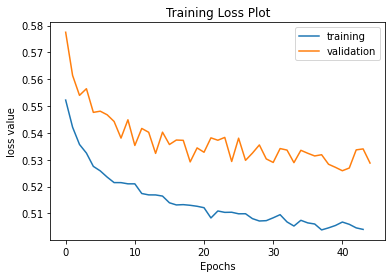

In [ ]:
# Loss Plot - Training and Validation
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("loss value")
plt.title("Training Loss Plot")
plt.legend(['training', 'validation'], loc='upper right')
plt.show()


(163200, 3)


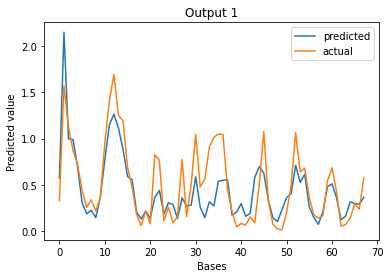

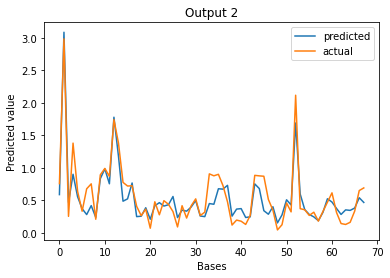

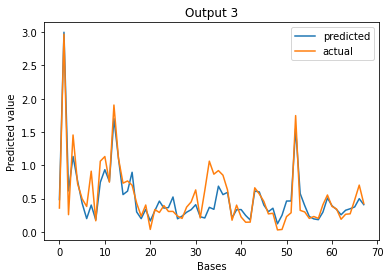

In [ ]:
# Show predictions
print(np.shape(predictions))
output1 = predictions[0:68,0]
output2 = predictions[0:68,1]
output3 = predictions[0:68,2]
actual1 = target[0:68,0]
actual2 = target[0:68,1]
actual3 = target[0:68,2]

plt.plot(output1)
plt.plot(actual1)
plt.xlabel("Bases")
plt.ylabel("Predicted value")
plt.title("Output 1")
plt.legend(['predicted', 'actual'], loc='upper right')
plt.show()


plt.plot(output2)
plt.plot(actual2)
plt.xlabel("Bases")
plt.ylabel("Predicted value")
plt.title("Output 2")
plt.legend(['predicted', 'actual'], loc='upper right')
plt.show()

plt.plot(output3)
plt.plot(actual3)
plt.xlabel("Bases")
plt.ylabel("Predicted value")
plt.title("Output 3")
plt.legend(['predicted', 'actual'], loc='upper right')
plt.show()